### Gold Price Prediction using Linear Regression ###

Using sklearns linear regression to attempt to predict the daily price of gold. 

Once regression model is built, I build a trade strategy using the predicted gold price values to backtest on out of sample data. 

Without accounting for slippage or transaction fees the model produces

 - Annualised return of 25.75%
 - Sharpe ratio of 1.28 


In [20]:

from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

#ignore warning
import warnings
warnings.filterwarnings('ignore')

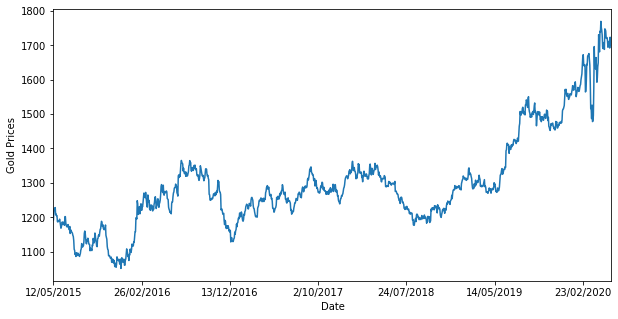

In [3]:
#read data 
Gold_df = pd.read_csv('Gold_data.csv', index_col = 0)

#df of close prices

df = Gold_df['Adj Close']

df.plot(figsize = (10,5))
plt.ylabel("Gold Prices")
plt.show()

In [4]:
Gold_df['S_3'] = Gold_df['Adj Close'].shift(1).rolling(window=3).mean()
Gold_df['S_9']= Gold_df['Adj Close'].shift(1).rolling(window=9).mean()
Gold_df= Gold_df.dropna()

# define explanitory variables 
X = Gold_df[['S_3','S_9']]
#X.head()

# define dependant variable 
y = Gold_df['Adj Close']

In [5]:
## Split into train and test sets 

t = 0.8

t = int(t*len(Gold_df))

# train dataset
X_train = X[:t]
y_train = y[:t]

# test set 
X_test = X[t:]
y_test = y[t:]


In [6]:
# build model on train set 
linear = LinearRegression().fit(X_train, y_train)

print ("Gold ETF Price =", round(linear.coef_[0],2), \
"* 3 Day Moving Average", round(linear.coef_[1],2), \
"* 9 Day Moving Average +", round(linear.intercept_,2))

Gold ETF Price = 1.25 * 3 Days Moving Average -0.26 * 9 Days Moving Average + 19.14


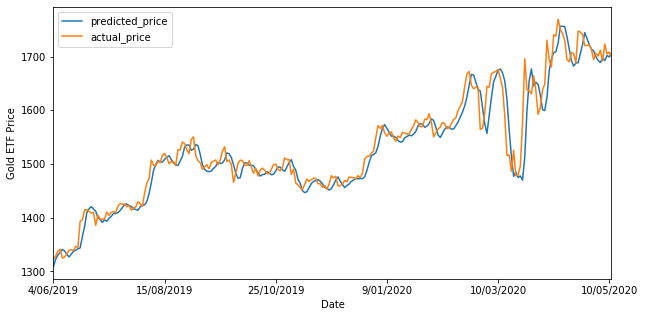

In [7]:
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price,index=y_test.index,columns = ['price'])
predicted_price.plot(figsize=(10,5))
y_test.plot()
plt.legend(['predicted_price','actual_price'])
plt.ylabel("Gold ETF Price")
plt.show() 

In [8]:
r2_score = linear.score(X[t:],y[t:])*100
float("{0:.2f}".format(r2_score))

93.34

In [21]:
trade  = predicted_price

trade['shifted_price'] = predicted_price.shift(1)

trade.dropna()

trade['l_s'] = np.where(trade.price > trade.shifted_price, 1, -1)


trade = pd.DataFrame(trade)

backtest = Gold_df.join(trade)

backtest['rets'] = backtest['Adj Close'].pct_change()

t = backtest[['Adj Close', 'l_s']]
t.dropna(subset = ['l_s'], inplace = True)
t

,Adj Close,l_s
Date,,
4/06/2019,1323.400024,-1.0
5/06/2019,1328.300049,1.0
6/06/2019,1337.599976,1.0
7/06/2019,1341.199951,1.0
10/06/2019,1324.699951,1.0
...,...,...
6/05/2020,1691.900024,1.0
7/05/2020,1723.199951,-1.0
8/05/2020,1704.800049,1.0


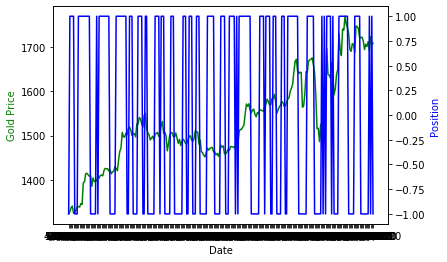

In [16]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t['Adj Close'], 'g-')
ax2.plot(t['l_s'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price', color='g')
ax2.set_ylabel('Position', color='b')

plt.show()

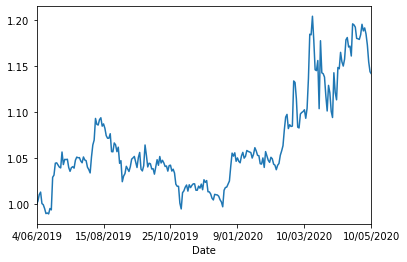

In [22]:
t['log_rets'] = np.log(t['Adj Close']) - np.log(t['Adj Close'].shift(1))

t['backtest'] = t.l_s * t.log_rets 

t.iloc[0, 3] = 1 
t.drop(t.tail(1).index, inplace = True)

t.backtest.cumsum().plot()

In [19]:
annualised_mean = t.log_rets.mean() * 252

annualised_std = t.log_rets.std() * np.sqrt(252)

sharpe = annualised_mean / annualised_std

print ('Annualised mean return: ' , annualised_mean)
print ('Sharpe ratio: ' , sharpe)


Annualised mean return:  0.2575138678135276
Sharpe ratio:  1.2804448578376353
